In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

from array import array
import ROOT

Welcome to JupyROOT 6.12/04


In [37]:
def poly_str(order):
    if order < 0:
        return ""
    
    o3_str = "[0] + [1]*x + [2]*x*x + [3]*x*x*x"
    if order == 0:
        return "[0]"
    elif order == 1:
        return "[0] + [1]*x"
    elif order == 2:
        return "[0] + [1]*x + [2]*x*x"
    elif order == 3:
        return o3_str
    else:
        return o3_str + " + "  + " + ".join(["[{}]*TMath::Power(x, {})".format(4+i, 4+i) for i in range(order-3)])

In [41]:
def fit_graph(file_name, can_name, obj_name, order):
    file_ = ROOT.TFile.Open(file_name)
    canvas = file_.Get(can_name)
    graph = canvas.GetPrimitive(obj_name)
#     graph.Print()
    x = list(graph.GetX())
    y = list(graph.GetY())
    poly = ROOT.TF1("poly", poly_str(order), min(x), max(x))
    
    parameters = array('d', [0]*(order+1))
    poly.SetParameters(parameters)
    results = graph.Fit('poly', 'S')
    
    file_.Close()
    return x, y, results

In [39]:
def TMatrix_to_numpy(matrix):
    nrows = matrix.GetNrows()
    ncols = matrix.GetNcols()
    mat_np = np.zeros((nrows, ncols))
    for ir in range(nrows):
        for ic in range(ncols):
            mat_np[ir][ic] = matrix[ir][ic]
    
    return mat_np

def jacobian(x, order):
    return np.array([x**(ii) for ii in range(order+1)])

def plot_band(x, y, results, x_label="None", y_label="None"):
    p = [x for x in results.Parameters()]
    V = TMatrix_to_numpy(results.GetCovarianceMatrix())
    
    order = len(p) - 1
    
    #p, V = np.polyfit(x, data, order, cov=True)
    # p is a array of bested fitted parameters, arranged such as high order comes first!
    # V is the covariance-variance matrix.
    fit_poly = np.poly1d(list(reversed(p)))
    true_x = np.linspace(min(x), max(x), 100)
    fitted_y = fit_poly(true_x)

    fitted_y_err = []
    for xi in true_x:
        variance_y = np.matmul(jacobian(xi, order), np.matmul(V, jacobian(xi, order).transpose()))
        fitted_y_err.append(np.sqrt(variance_y))
    fitted_y_err = np.array(fitted_y_err)

    fitted_y_up = fitted_y + fitted_y_err
    fitted_y_down = fitted_y - fitted_y_err
    
    y_err = [np.sqrt(np.matmul(jacobian(xi, order), np.matmul(V, jacobian(xi, order).transpose()))) for xi in x]

    plt.plot(x, y, '*', label='data')
    plt.plot(true_x, fitted_y, '--', label='fitted')
    plt.fill_between(true_x, fitted_y_down, fitted_y_up, color='orange')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    return fit_poly(x), y_err

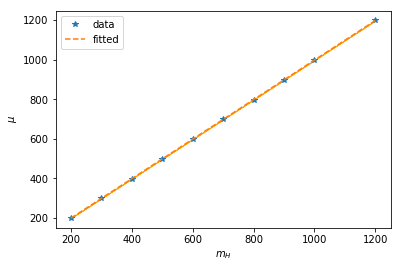

 FCN=11.4286 FROM MIGRAD    STATUS=CONVERGED     125 CALLS         126 TOTAL
                     EDM=6.32042e-15    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.97576e-03   2.23666e-01   4.37570e-05  -4.68884e-07
   2  p1           9.96686e-01   1.49785e-03   4.75257e-07  -3.41511e-05
   3  p2           3.04713e-06   2.77700e-06   1.46223e-10  -1.79491e-02
   4  p3          -8.12396e-10   1.50644e-09   3.00000e-12   7.61907e+00


In [42]:
fit_y, y_err = plot_band(
    * (fit_graph('../data/gg_parametrization_fit_2mu2e.root', 'canvas_mass_mean_2mu2e', 'graph_mass_mean_2mu2e', 3)),
    x_label="$m_H$", y_label="$\mu$")

In [43]:
print(y_err)

[0.037118281895506859, 0.035230729368041766, 0.045587910072667832, 0.047670312139676825, 0.051419713678630609, 0.062356660807383467, 0.075160027854758948, 0.084994282197399004, 0.099531003062444889, 0.24335519403577638]


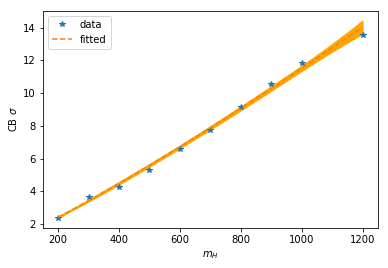

 FCN=15.3468 FROM MIGRAD    STATUS=CONVERGED     115 CALLS         116 TOTAL
                     EDM=2.2942e-19    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.04767e-01   3.68055e-01   7.93260e-05  -1.06367e-09
   2  p1           9.05152e-03   2.52105e-03   2.01537e-07  -1.54246e-07
   3  p2           2.48901e-06   4.67973e-06   2.82854e-10   1.25602e-04
   4  p3          -5.33061e-10   2.53796e-09   3.08515e-13  -2.87889e-02


In [44]:
fit_y, y_err = plot_band(
    * (fit_graph('../data/gg_parametrization_fit_2mu2e.root', 'canvas_mass_cb_sigma_2mu2e', 'graph_mass_cb_sigma_2mu2e', 3)),
    x_label="$m_H$", y_label="CB $\sigma$")

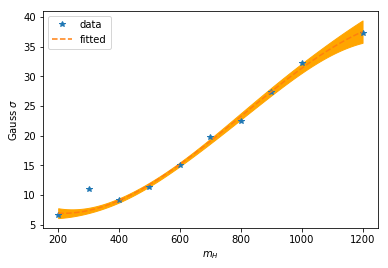

 FCN=4.98091 FROM MIGRAD    STATUS=CONVERGED     112 CALLS         113 TOTAL
                     EDM=3.8413e-20    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.06821e+01   2.89961e+00   2.97443e-04  -3.73256e-11
   2  p1          -3.66980e-02   1.55984e-02   5.20283e-07   5.54810e-08
   3  p2           9.80725e-05   2.59274e-05   7.22736e-10   3.68674e-05
   4  p3          -4.06894e-08   1.31839e-08   9.07273e-13   1.71317e-02


In [46]:
fit_y, y_err = plot_band(
    * (fit_graph('../data/gg_parametrization_fit_2mu2e.root', 'canvas_mass_gauss_sigma_2mu2e', 'graph_mass_gauss_sigma_2mu2e', 3)),
    x_label="$m_H$", y_label="Gauss $\sigma$")